#  Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# План работы
- Изучить файл с данными.
- Проверить данные на пропуски, дубликаты, выбросы.
- Выполнить ресемплирование.
- Визуализировать данные.
- Провести предобработку данных.
- Разбить данные на две выборки в соотношении 90:10 : обучающая, тестовая.
- Обучить разные модели.
- Проанализировать скорость работы, качество модели и добиться RMSE ниже 48.

## Подготовка

Импортируем библиотеки и прочтём файл

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import lightgbm as lgb
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings 
warnings.filterwarnings('ignore')
import time

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Индекс упорядочен:',data.index.is_monotonic)
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [4]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])

In [5]:
check(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB

Индекс упорядочен: True
Кол-во дубликатов - 26415

Кол-во пропусков:
num_orders    0
dtype: int64

Процент пропусков:
num_orders    0.0
dtype: float64
---------------------------

Cтолбец num_orders
Кол-во уникальных значений - 81
Кол-во пропусков - 0
Кол-во дубликатов - 26415

9     1373
11    1365
12    1317
10    1316
8     1253
Name: num_orders, dtype: int64



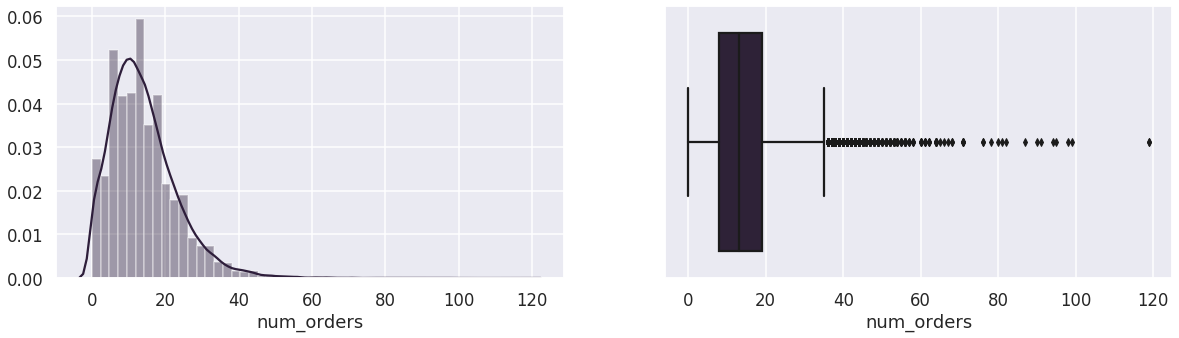

In [6]:
charts(data, 'num_orders','')

**Промежуточные выводы:** Имеются дубли и отсутвуют пропуски. Данные монотонны. Имеются выбросы

## Анализ

Проведем ресемплинг по месяцам и неделям, построим графики.

In [7]:
month = data.resample('1M').sum()
week = data.resample('1W').sum()

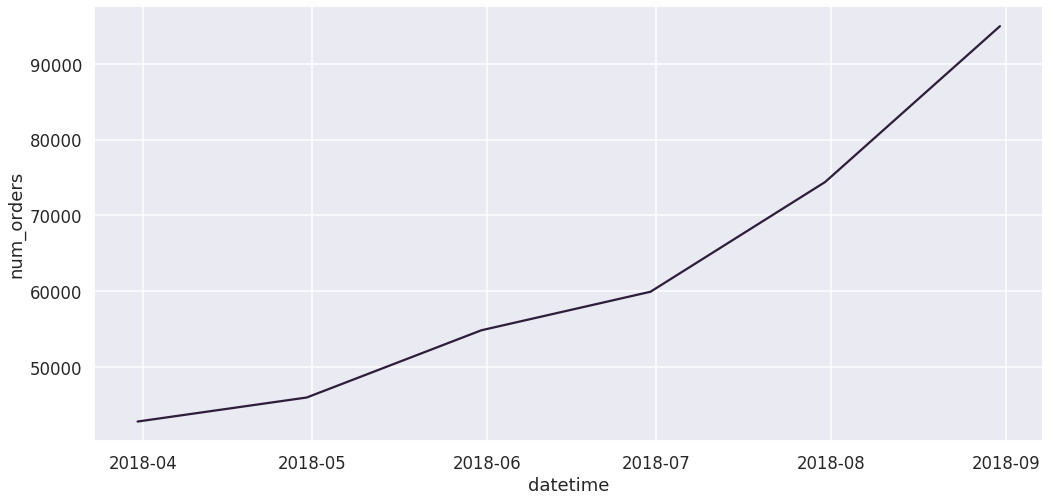

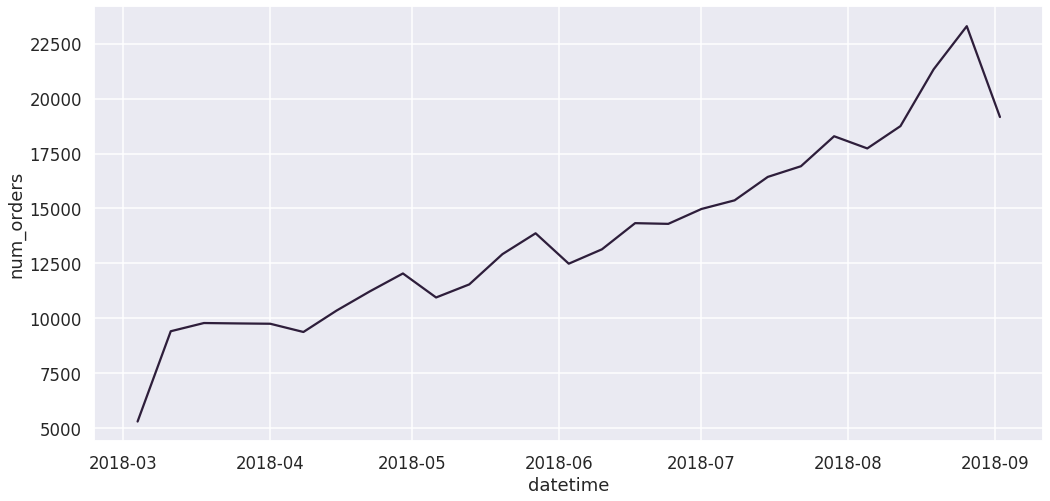

In [8]:
plt.figure(figsize=(17,8))
sns.lineplot(x=month.index, y= month['num_orders'])

plt.figure(figsize=(17,8))
sns.lineplot(x=week.index, y=week['num_orders'])

**Промежуточные выводы:** Имеется постепенное увеличение количества заказов на протяжении имеющегося периода.

### Тренды и сезонность 

Подготовим данные. Ресемплирование по часу, просуммируем заказы. Разлоим временной ряд на три составляющие: тренд, сезонность и остаток

In [9]:
#скользящее среднее и скользящее стандартное отклонение
decom = data.copy()
decom = decom.resample('1H').sum()
decom['rolling'] = decom['num_orders'].shift().rolling(10).mean()
decom['std'] = decom['num_orders'].rolling(10).std()

In [10]:
check(decom)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 3 columns):
num_orders    4416 non-null int64
rolling       4406 non-null float64
std           4407 non-null float64
dtypes: float64(2), int64(1)
memory usage: 138.0 KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
num_orders     0
rolling       10
std            9
dtype: int64

Процент пропусков:
rolling       0.226449
std           0.203804
num_orders    0.000000
dtype: float64
---------------------------

Cтолбец num_orders
Кол-во уникальных значений - 251
Кол-во пропусков - 0
Кол-во дубликатов - 4165

73    65
57    58
66    58
78    54
84    52
Name: num_orders, dtype: int64


Cтолбец rolling
Кол-во уникальных значений - 1179
Кол-во пропусков - 10
Кол-во дубликатов - 3236

68.6    14
82.4    13
72.2    12
56.9    12
89.8    12
Name: rolling, dtype: int64


Cтолбец std
Кол-во уникальных значений - 4373
Кол-во пропусков - 9
Ко

In [11]:
decom.dropna(inplace=True)
decom = seasonal_decompose(decom)

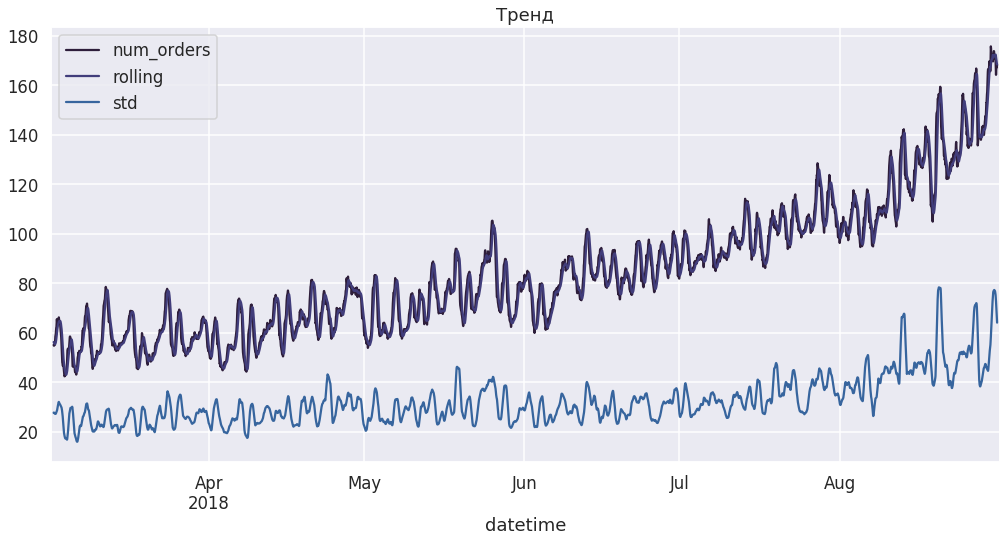

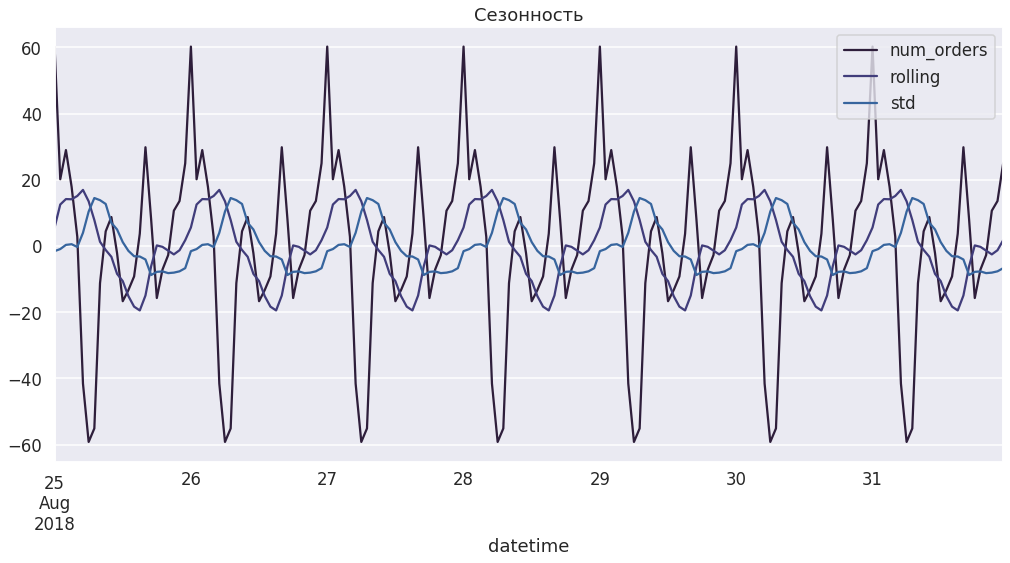

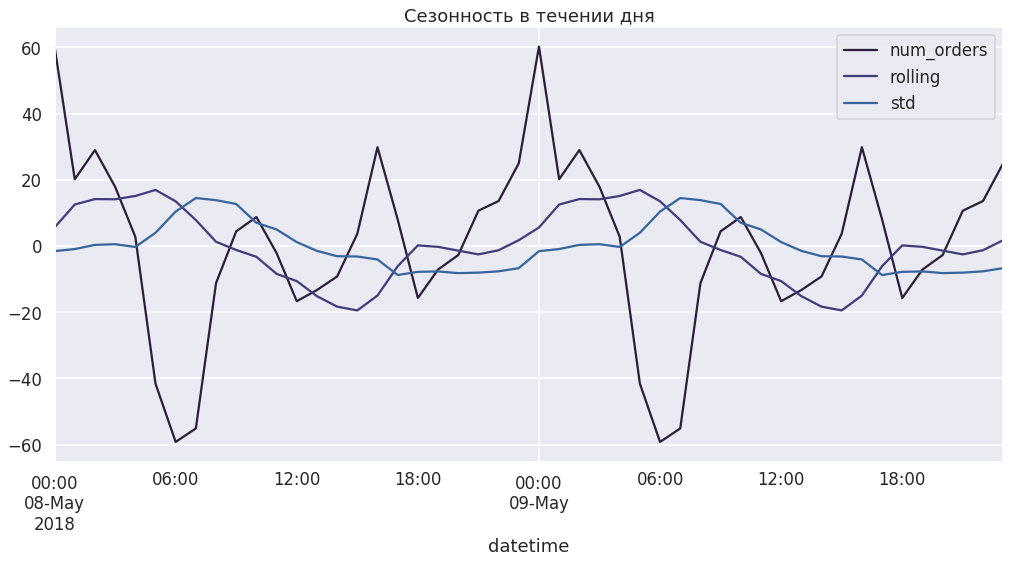

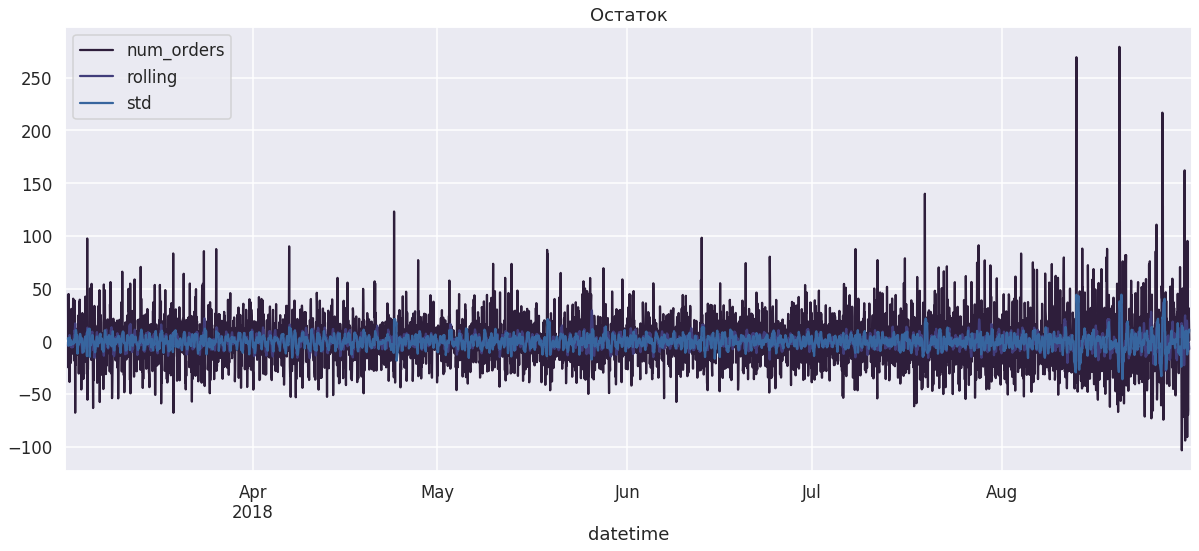

In [12]:
#графики
decom.trend.plot(title='Тренд', figsize=(17,8))
decom.seasonal.tail(24*7).plot(title='Сезонность', figsize=(17,8))
plt.figure(figsize=(15, 4))
decom.seasonal['2018-05-8':'2018-05-9'].plot(ax=plt.gca(), figsize=(17,8))
plt.title('Сезонность в течении дня')
plt.figure(figsize=(15, 4))
decom.resid.plot(ax=plt.gca(),figsize=(17,8))
plt.title('Остаток')
plt.tight_layout()

**Промежуточные выводы:** Можно отметить, что имеется тренд на увеличение заказов. Также, ночью спрос на такси больше, чем в любое другое время суток. Стохастический процесс нестационарный.

## Обучение

### Подготовка данных

In [15]:
#создаем признаки
data = data.resample('1H').sum()

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 10,10)

In [16]:
print('Shape:',data.shape)
print()
print('Nan sum:')
print(data.isna().sum())

Shape: (4416, 14)

Nan sum:
num_orders       0
dayofweek        0
hour             0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
rolling_mean    10
dtype: int64


In [17]:
#удалим пропуски
data = data.dropna()

#разделим данные на обучающую и тестувую выборки в соотношении 90:10
train, test = train_test_split(data, shuffle=False, test_size=0.1)

#обучающая
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

#тестовая
test_features = test.drop(['num_orders'],axis=1)
test_target = test['num_orders']

In [18]:
print('Размер train выборки - {}'.format(train.shape))
print('Размер test выборки - {}'.format(test.shape))

Размер train выборки - (3965, 14)
Размер test выборки - (441, 14)


###  Линейная регрессия, Случайный лес регрессия, Древо решений регрессия

In [19]:
model_1 = LinearRegression()
model_2 = RandomForestRegressor(random_state=12345)
model_3 = DecisionTreeRegressor(random_state=12345)

param_LR = {'fit_intercept':[True,False], 'copy_X':[True, False], 
                  'normalize':[True,False]}
param_RF = {'n_estimators':[5,100],
             'max_depth':[1,10], 'min_samples_split': [2, 3]}
param_DT= {'max_depth':[1,20], 'splitter':('best','random'), 'min_samples_split':np.arange(2,10)}

cv = TimeSeriesSplit(n_splits=7)

In [20]:
LR = GridSearchCV(model_1 ,param_grid = param_LR, cv=cv)
RF = GridSearchCV(model_2,param_grid = param_RF, cv=cv)
DT = GridSearchCV(model_3,param_grid = param_DT, cv=cv)

Эти три модели обучим и прогоним сразу через тестовую.

In [21]:
%%time
#Линейная регрессия
start_1 = time.time()
LR.fit(train_features, train_target)
end_1 = time.time()
fit_LR = end_1 - start_1

start_2 = time.time()
prediction_LR = LR.predict(test_features)
end_2 = time.time()
pred_LR = end_2 - start_2

rmse_LR = (mean_squared_error(test_target, prediction_LR) ** 0.5)
r2_LR = r2_score(test_target, prediction_LR)

print('\n========================================================')
print('Линейная регрессия')
print('========================================================')
print('RMSE:', round(rmse_LR, 4))
print('R2:', round(r2_LR, 4))
print('Время обучения:', round(fit_LR,4), 'vs', 'Время предсказания', round(pred_LR,4))
print()
print('Наилучшие гиперпараметры:',LR.best_params_)
print()


Линейная регрессия
RMSE: 54.0959
R2: 0.1475
Время обучения: 1.2418 vs Время предсказания 0.0016

Наилучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'normalize': True}

CPU times: user 801 ms, sys: 511 ms, total: 1.31 s
Wall time: 1.25 s


In [22]:
%%time
#Cлучаный лес регрессия
start_1 = time.time()
RF.fit(train_features, train_target)
end_1 = time.time()
fit_RF = end_1 - start_1

start_2 = time.time()
prediction_RF = RF.predict(test_features)
end_2 = time.time()
pred_RF = end_2 - start_2

rmse_RF = (mean_squared_error(test_target, prediction_RF) ** 0.5)
r2_RF = r2_score(test_target, prediction_RF)

print('\n========================================================')
print('Случаный лес регрессия')
print('========================================================')
print('RMSE:', round(rmse_RF, 4))
print('R2:', round(r2_RF, 4))
print('Время обучения:', round(fit_RF,4), 'vs', 'Время предсказания', round(pred_RF,4))
print()
print('Наилучшие гиперпараметры:',RF.best_params_)
print()


Случаный лес регрессия
RMSE: 47.2514
R2: 0.3496
Время обучения: 22.3564 vs Время предсказания 0.0105

Наилучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

CPU times: user 22.1 s, sys: 51.9 ms, total: 22.2 s
Wall time: 22.4 s


In [23]:
%%time
#Древо решений регрессия
start_1 = time.time()
DT.fit(train_features, train_target)
end_1 = time.time()
fit_DT = end_1 - start_1

start_2 = time.time()
prediction_DT = DT.predict(test_features)
end_2 = time.time()
pred_DT = end_2 - start_2

rmse_DT = (mean_squared_error(test_target, prediction_DT) ** 0.5)
r2_DT = r2_score(test_target, prediction_DT)

print("\n========================================================")
print("Древо решений регрессия" )
print("========================================================")
print('RMSE:', round(rmse_DT, 4))
print('R2:', round(r2_DT, 4))
print('Время обучения:', round(fit_DT,4), 'vs', 'Время предсказания', round(pred_DT,4))
print()
print('Наилучшие гиперпараметры:',DT.best_params_)
print()


Древо решений регрессия
RMSE: 51.9356
R2: 0.2142
Время обучения: 2.5977 vs Время предсказания 0.0013

Наилучшие гиперпараметры: {'max_depth': 20, 'min_samples_split': 9, 'splitter': 'best'}

CPU times: user 2.57 s, sys: 11.6 ms, total: 2.59 s
Wall time: 2.6 s


**Промежуточные выводы:** Модель Случайный Лес регрессия показала себя лучше остальных. RMSE: 47.2, что удовлетворяет условие меньше 48. Время обучения: 22.3564 vs Время предсказания 0.0105.

### CatBoostRegressor

In [24]:
%%time
cat = CatBoostRegressor(loss_function='RMSE', depth=5, n_estimators = 500, learning_rate = 0.1)

start = time.time()
cat.fit(train_features, train_target,eval_set=[(test_features, test_target),], verbose = 100)
end = time.time()
fit_cat = end - start

prediction_cat = cat.predict(train_features)

rmse_cat = (mean_squared_error(train_target, prediction_cat) ** 0.5)
   
print("\n========================================================")
print("CatBoost" )
print("========================================================")
print('RMSE:', round(rmse_cat, 4))
print('Время обучения:', round(fit_cat,4))
print()

0:	learn: 37.0452403	test: 82.6921919	best: 82.6921919 (0)	total: 55.1ms	remaining: 27.5s
100:	learn: 21.5836419	test: 46.3598738	best: 46.3598738 (100)	total: 2.44s	remaining: 9.62s
200:	learn: 18.8812292	test: 43.9320849	best: 43.9320849 (200)	total: 4.91s	remaining: 7.3s
300:	learn: 17.3714335	test: 43.6344738	best: 43.4541110 (286)	total: 7.39s	remaining: 4.88s
400:	learn: 16.2406177	test: 43.4242220	best: 43.3899249 (394)	total: 9.93s	remaining: 2.45s
499:	learn: 15.2793208	test: 43.6073988	best: 43.3882707 (407)	total: 12.3s	remaining: 0us

bestTest = 43.38827068
bestIteration = 407

Shrink model to first 408 iterations.

CatBoost
RMSE: 16.1729
Время обучения: 14.4009

CPU times: user 10.6 s, sys: 2.08 s, total: 12.7 s
Wall time: 14.4 s


### LGBMRegressor

In [25]:
%%time
lgbm = lgb.LGBMRegressor(num_leaves=12, n_estimators=500)

start = time.time()
lgbm.fit(train_features, train_target, verbose = 100, eval_set=[(test_features, test_target),], eval_metric='rmse')
end = time.time()
fit_lgbm = end - start

prediction_lgbm = lgbm.predict(train_features)


rmse_lgbm = (mean_squared_error(train_target, prediction_lgbm) ** 0.5)

print("\n========================================================")
print("LGBMRegressor" )
print("========================================================")
print('RMSE:', round(rmse_lgbm, 4))
print('Время обучения:', round(fit_lgbm,4))


[100]	valid_0's rmse: 44.8737	valid_0's l2: 2013.65
[200]	valid_0's rmse: 43.6335	valid_0's l2: 1903.88
[300]	valid_0's rmse: 43.8176	valid_0's l2: 1919.98
[400]	valid_0's rmse: 43.9859	valid_0's l2: 1934.76
[500]	valid_0's rmse: 44.1099	valid_0's l2: 1945.69

LGBMRegressor
RMSE: 11.8864
Время обучения: 655.5095
CPU times: user 10min 45s, sys: 6.09 s, total: 10min 51s
Wall time: 10min 55s


**Промежуточные выводы:** На обучающей выборке себя лучше показал LGBMRegressor, но время обучения слишком долгое. Прогоним эти две модели через тестовую выборку.

## Тестирование

### CatBoostRegressor

In [26]:
%%time

start = time.time()
prediction_cat_test = cat.predict(test_features)
end = time.time()

pred_cat = end - start

rmse_cat_test = (mean_squared_error(test_target, prediction_cat_test) ** 0.5)

print("\n========================================================")
print("CatBoost" )
print("========================================================")
print('RMSE:', round(rmse_cat_test, 4))
print('Время предсказания:', round(pred_cat,4))
print()


CatBoost
RMSE: 43.3883
Время предсказания: 0.0022

CPU times: user 2.88 ms, sys: 4.22 ms, total: 7.1 ms
Wall time: 3.47 ms


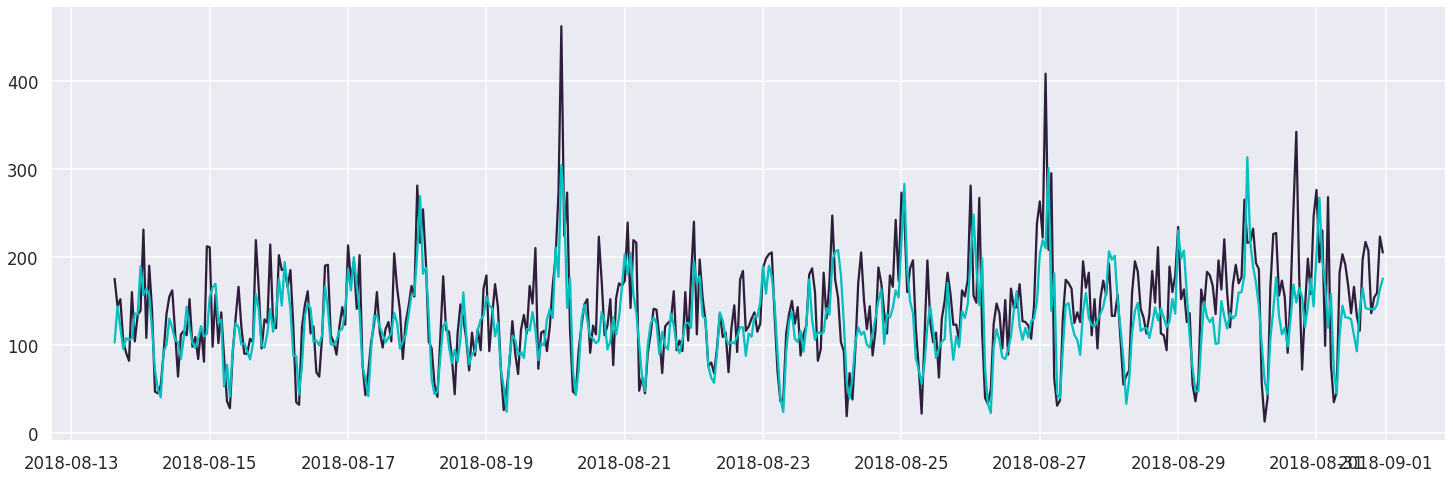

In [48]:
#график CatBoost
plt.figure(figsize=(25,8))
plt.plot(test_target.index, 
         test_target, 
         '-', 
         test_target.index, 
         prediction_cat_test,
         'c-')

### LGBMRegressor

In [27]:
%%time

start = time.time()
prediction_lgbm_test = lgbm.predict(test_features)
end = time.time()

pred_lgbm = end - start

rmse_lgbm_test = (mean_squared_error(test_target, prediction_lgbm_test) ** 0.5)

print("\n========================================================")
print("LGBMRegressor" )
print("========================================================")
print('RMSE:', round(rmse_lgbm_test, 4))
print()
print('Время предсказания:', round(pred_lgbm,4))


LGBMRegressor
RMSE: 44.1099

Время предсказания: 0.0234
CPU times: user 65.2 ms, sys: 3.97 ms, total: 69.2 ms
Wall time: 27.3 ms


**Промежуточные выводы:** На тестовой выборке, с небольшим перевесом, себя лучше показал CatBoost. RMSE: 43.3883, а время предсказания: 0.0022.

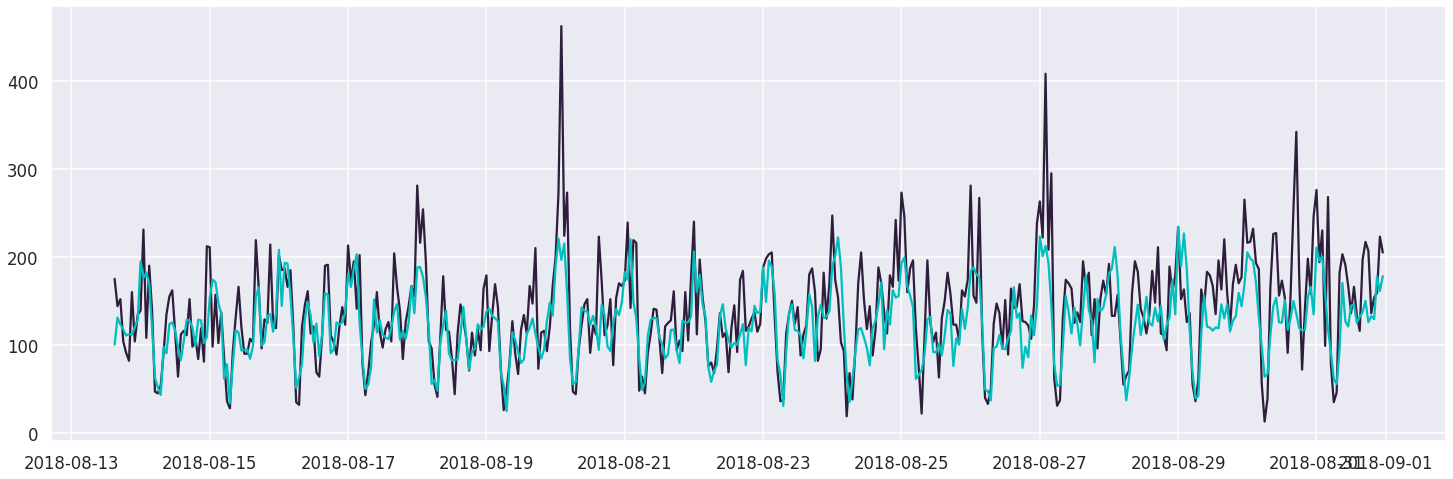

In [49]:
#график LGBM
plt.figure(figsize=(25,8))
plt.plot(test_target.index, 
         test_target, 
         '-', 
         test_target.index, 
         prediction_lgbm_test,
         'c-')

## Вывод

Перед нами стояла задача построить модель для прогнозирования количества заказов такси на час вперед и добиться значения метрики RMSE на тестовой выборке не больше 48.

Итак, среди простых моделей можно выделить алгоритм Случайный Лес Регрессия. А что касается CatBoost и LightGBM, оба алгоритма показали неплохие результаты RMSE с небольшим перевесом в пользу CatBoost. Также стоит отметить, что LightGBM показал плохие результаты по скорости обучения. По итогам исследования из полученных результатов можно выделить следующие решения для заказчика:
- Если выбирать из простых моделей, то однозначно — Случайный Лес Регрессия
- Если важна точность и важна скорость предсказания — CatBoostRegressor